#1. Install packages

In [ ]:
!pip install stellargraph
!pip install node2vec==0.3.3
!pip install scikit-network

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 435 kB 5.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for node2vec: filename=node2vec-0.3.3-py3-none-any.whl size=5673 sha256=b417449f86166e34ab5a1b636d73c788a30a969221cfbf9208e2a409c7a03a51
  Stored in directory: /root/.cache/pip/wheels/da/ba/7d/e3e173c4133d8b8c498981bdd8b115e4bd5dcf6c314e513fa6
Successfully built node2vec
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.3 MB/s 
     |████████████████████████████████| 8.1 MB 6.5 MB/s 


In [ ]:
import os
import math
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

%matplotlib inline

# 2. Load dataset and preprocessing

In [ ]:
disease_network = pd.read_csv("disease_network2.csv")

In [ ]:
disease_network

,source,target,weight
0,0,1136,1
1,0,480,1
2,0,1121,1
3,0,814,1
4,1,849,7
...,...,...,...
37894,1236,1238,3
37895,1236,1276,1
37896,1237,1238,1
37897,1238,1253,2


In [ ]:
disease_network=disease_network.drop(['weight'], axis=1)

In [ ]:
G = nx.from_pandas_edgelist(disease_network, create_using=nx.Graph())
nx.info(G)

'Graph with 1375 nodes and 37899 edges'

In [ ]:
print(nx.to_pandas_edgelist(G))

       source  target
0           0    1136
1           0     480
2           0    1121
3           0     814
4        1136       1
...       ...     ...
37894     872     708
37895     487    1360
37896     487     919
37897    1360     919
37898     558    1161

[37899 rows x 2 columns]


# 3. Network topology

In [ ]:
nx.connected_components(G)

<generator object connected_components at 0x7f1179c43c50>

In [ ]:
for g in (G.subgraph(c) for c in nx.connected_components(G)):
    print(nx.average_shortest_path_length(g))

2.2566022351090056
1.0


In [ ]:
nx.degree_pearson_correlation_coefficient(G)

-0.24955868406243653

In [ ]:
nx.transitivity(G)

0.3243138352661088

In [ ]:
nx.average_clustering(G)

0.6686639004134475

In [ ]:
bC = nx.betweenness_centrality(G)

In [ ]:
np.mean(list(bC.values()))

0.0009125622689265877

In [ ]:
deg_C = nx.degree_centrality(G)

In [ ]:
np.mean(list(deg_C.values()))

0.04012068281063915

In [ ]:
close_C = nx.closeness_centrality(G)

In [ ]:
np.mean(list(close_C.values()))

0.44912475000731966

In [ ]:
# train test split
from sklearn.model_selection import train_test_split
from stellargraph.data import EdgeSplitter
from stellargraph import StellarGraph

edgeSplitter = EdgeSplitter(G) 
graph_test, samples_test, labels_test = edgeSplitter.train_test_split(p=0.1, method="global", seed=1)

edgeSplitter = EdgeSplitter(graph_test, G) 
graph_train, samples_train, labels_train = edgeSplitter.train_test_split(p=0.1, method="global", seed=1)

** Sampled 3789 positive and 3789 negative edges. **
** Sampled 3411 positive and 3411 negative edges. **


# 4. Node2Vec

In [ ]:
from node2vec import Node2Vec
from node2vec.edges import HadamardEmbedder 
from stellargraph.data import EdgeSplitter 

node2vec = Node2Vec(graph_train) 
model = node2vec.fit() 
edges_embs = HadamardEmbedder(keyed_vectors=model.wv) 
train_embeddings = [edges_embs[str(x[0]),str(x[1])] for x in samples_train]

edges_embs = HadamardEmbedder(keyed_vectors=model.wv) 
test_embeddings = [edges_embs[str(x[0]),str(x[1])] for x in samples_test]

Generating walks (CPU: 1): 100%|██████████| 10/10 [01:12<00:00,  7.20s/it]


In [ ]:
### distance and t-sne

In [ ]:
from sklearn.manifold import TSNE
import sklearn
from sklearn.decomposition import PCA
transform = TSNE

In [ ]:
pca = transform(n_components=2, random_state=42)
weighted_node_embeddings_2d = pca.fit_transform(train_embeddings)



/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
groups = pd.DataFrame(weighted_node_embeddings_2d, columns=['x', 'y']).assign(category=labels_train)

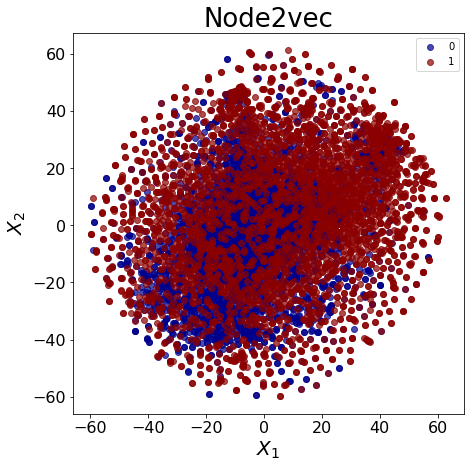

In [ ]:
import numpy as np
names = ['1', '0']

fig, ax = plt.subplots(figsize=(7, 7))

X_label1 = groups.query('category==1')
X_label0= groups.query('category==0')
ax.scatter(X_label0['x'], X_label0['y'],alpha=0.7,label=names[1], c='darkblue')
ax.scatter(X_label1['x'], X_label1['y'],alpha=0.7,label=names[0],c='darkred')

ax.set_xlabel('$X_1$',  fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.set_ylabel('$X_2$', fontsize=20)
ax.set_title('Node2vec', fontsize=26)
ax.legend()
plt.savefig('node2vec.png')

In [ ]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics 

rf = RandomForestClassifier(random_state=1) 
rf.fit(train_embeddings, labels_train); 
 
y_pred = rf.predict(test_embeddings) 


In [ ]:
print(confusion_matrix(labels_test, y_pred))
print(classification_report(labels_test, y_pred, digits=4))

[[2760 1029]
 [ 256 3533]]
              precision    recall  f1-score   support

           0     0.9151    0.7284    0.8112      3789
           1     0.7744    0.9324    0.8461      3789

    accuracy                         0.8304      7578
   macro avg     0.8448    0.8304    0.8286      7578
weighted avg     0.8448    0.8304    0.8286      7578



In [ ]:
print('Precision:', metrics.precision_score(labels_test, y_pred)) 
print('Recall:', metrics.recall_score(labels_test, y_pred)) 
print('F1-Score:', metrics.f1_score(labels_test, y_pred)) 
print('Accuracy:', metrics.accuracy_score(labels_test, y_pred)) 

Precision: 0.7744410346339324
Recall: 0.9324359989443125
F1-Score: 0.846126212429649
Accuracy: 0.8304301926629718


In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=1) 
lr.fit(train_embeddings, labels_train); 
 
y_pred = lr.predict(test_embeddings)


In [ ]:
print(confusion_matrix(labels_test, y_pred))
print(classification_report(labels_test, y_pred, digits=4))

[[2997  792]
 [1298 2491]]
              precision    recall  f1-score   support

           0     0.6978    0.7910    0.7415      3789
           1     0.7588    0.6574    0.7045      3789

    accuracy                         0.7242      7578
   macro avg     0.7283    0.7242    0.7230      7578
weighted avg     0.7283    0.7242    0.7230      7578



In [ ]:
import xgboost as xgb
train_embeddings_xgboost = np.array(train_embeddings)

xgb = xgb.XGBClassifier(random_state=1)
xgb.fit(train_embeddings_xgboost, labels_train); 
 
y_pred = xgb.predict(test_embeddings)


In [ ]:
print(confusion_matrix(labels_test, y_pred))
print(classification_report(labels_test, y_pred, digits=4))

[[3094  695]
 [ 506 3283]]
              precision    recall  f1-score   support

           0     0.8594    0.8166    0.8375      3789
           1     0.8253    0.8665    0.8454      3789

    accuracy                         0.8415      7578
   macro avg     0.8424    0.8415    0.8414      7578
weighted avg     0.8424    0.8415    0.8414      7578



# 5. GCN

In [ ]:

import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import FullBatchLinkGenerator
from stellargraph.layer import GCN, LinkEmbedding


from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection

from stellargraph import globalvar
from stellargraph import datasets
from IPython.display import display, HTML
%matplotlib inline

In [ ]:
eye = np.eye(graph_train.number_of_nodes())
fake_features = {n:eye[n] for n in G.nodes()}
nx.set_node_attributes(graph_train, fake_features, "fake")

eye = np.eye(graph_test.number_of_nodes())
fake_features = {n:eye[n] for n in G.nodes()}
nx.set_node_attributes(graph_test, fake_features, "fake")

In [ ]:
from stellargraph.mapper import FullBatchLinkGenerator



sg_graph_train = StellarGraph.from_networkx(graph_train, node_features="fake")
sg_graph_test = StellarGraph.from_networkx(graph_test, node_features="fake")

train_gen = FullBatchLinkGenerator(sg_graph_train,method="gcn")
train_flow = train_gen.flow(samples_train, labels_train)

test_gen = FullBatchLinkGenerator(sg_graph_test, method="gcn")
test_flow = test_gen.flow(samples_test, labels_test)

Using GCN (local pooling) filters...
Using GCN (local pooling) filters...


In [ ]:
from stellargraph.layer import GCN, LinkEmbedding
import random
RANDOM_SEED = 1
random.seed(RANDOM_SEED)

gcn = GCN(
    layer_sizes=[64, 64], activations=["relu", "relu"], generator=train_gen, dropout=0.5)

x_inp, x_out = gcn.in_out_tensors()

prediction = LinkEmbedding(activation="sigmoid", method="ip")(x_out)

model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=0.01),
    loss=keras.losses.binary_crossentropy,
    metrics=["acc"],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor="val_acc", patience=100, restore_best_weights=True)

In [ ]:
epochs = 500
history = model.fit(train_flow, epochs=epochs, validation_data=test_flow, verbose = 2, shuffle =False, callbacks=[es_callback],)

Epoch 1/500
1/1 - 4s - loss: 0.6931 - acc: 0.5060 - val_loss: 0.6883 - val_acc: 0.5000 - 4s/epoch - 4s/step
Epoch 2/500
1/1 - 0s - loss: 0.6884 - acc: 0.5000 - val_loss: 0.6699 - val_acc: 0.5000 - 164ms/epoch - 164ms/step
Epoch 3/500
1/1 - 0s - loss: 0.6709 - acc: 0.5000 - val_loss: 0.6342 - val_acc: 0.5000 - 168ms/epoch - 168ms/step
Epoch 4/500
1/1 - 0s - loss: 0.6346 - acc: 0.5000 - val_loss: 0.6042 - val_acc: 0.5000 - 165ms/epoch - 165ms/step
Epoch 5/500
1/1 - 0s - loss: 0.6077 - acc: 0.5000 - val_loss: 0.6204 - val_acc: 0.5000 - 186ms/epoch - 186ms/step
Epoch 6/500
1/1 - 0s - loss: 0.6228 - acc: 0.5000 - val_loss: 0.6160 - val_acc: 0.5000 - 179ms/epoch - 179ms/step
Epoch 7/500
1/1 - 0s - loss: 0.6219 - acc: 0.5000 - val_loss: 0.5934 - val_acc: 0.5000 - 169ms/epoch - 169ms/step
Epoch 8/500
1/1 - 0s - loss: 0.5990 - acc: 0.5000 - val_loss: 0.5847 - val_acc: 0.5000 - 174ms/epoch - 174ms/step
Epoch 9/500
1/1 - 0s - loss: 0.5887 - acc: 0.5000 - val_loss: 0.5875 - val_acc: 0.5000 - 167ms

In [ ]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 82ms/step - loss: 0.5334 - acc: 0.8011

Train Set Metrics of the trained model:
	loss: 0.5299
	acc: 0.8001

Test Set Metrics of the trained model:
	loss: 0.5334
	acc: 0.8011


In [ ]:
test_predictions = np.round(model.predict(test_flow)).flatten()

1/1 [==============================] - 0s 218ms/step


In [ ]:
print(confusion_matrix(labels_test, test_predictions))
print(classification_report(labels_test, test_predictions, digits=4))

[[2839  950]
 [ 557 3232]]
              precision    recall  f1-score   support

           0     0.8360    0.7493    0.7903      3789
           1     0.7728    0.8530    0.8109      3789

    accuracy                         0.8011      7578
   macro avg     0.8044    0.8011    0.8006      7578
weighted avg     0.8044    0.8011    0.8006      7578



# 6. GraphSAGE

In [ ]:
from stellargraph.mapper import GraphSAGELinkGenerator

batch_size = 32
num_samples = [20, 10]

sg_graph_train = StellarGraph.from_networkx(graph_train, node_features="fake")
sg_graph_test = StellarGraph.from_networkx(graph_test, node_features="fake")

train_gen = GraphSAGELinkGenerator(sg_graph_train, batch_size, num_samples)
train_flow = train_gen.flow(samples_train, labels_train, shuffle=True, seed=24)

test_gen = GraphSAGELinkGenerator(sg_graph_test, batch_size, num_samples)
test_flow = test_gen.flow(samples_test, labels_test, seed=24)

In [ ]:
from stellargraph.layer import GraphSAGE, link_classification
from tensorflow import keras

layer_sizes = [16, 16]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=train_gen, bias=True, dropout=0.5
)

x_inp, x_out = graphsage.in_out_tensors()

prediction = link_classification(
    output_dim=1, output_act="sigmoid", edge_embedding_method="ip"
)(x_out)

model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=0.01),
    loss=keras.losses.mse,
    metrics=["acc"],
)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
epochs = 30
history = model.fit(train_flow, epochs=epochs, validation_data=test_flow)

In [ ]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

In [ ]:
test_predictions = np.round(model.predict(test_flow)).flatten()

In [ ]:
print(confusion_matrix(labels_test, test_predictions))
print(classification_report(labels_test, test_predictions, digits=4))

In [ ]:
# with feature 

In [ ]:
from stellargraph.mapper import FullBatchLinkGenerator
feature_dict_train = dict(zip(graph_train_feature.index, graph_train_feature.values))
feature_dict_test = dict(zip(graph_test_feature.index, graph_test_feature.values))
nx.set_node_attributes(graph_train, feature_dict_train, "feature1")
nx.set_node_attributes(graph_test, feature_dict_test, "feature1")

In [ ]:
from stellargraph.mapper import GraphSAGELinkGenerator

batch_size = 32
num_samples = [20, 10]

sg_graph_train = StellarGraph.from_networkx(graph_train, node_features="feature1")
sg_graph_test = StellarGraph.from_networkx(graph_test, node_features="feature1")

train_gen = GraphSAGELinkGenerator(sg_graph_train, batch_size, num_samples)
train_flow = train_gen.flow(samples_train, labels_train, shuffle=True, seed=24)

test_gen = GraphSAGELinkGenerator(sg_graph_test, batch_size, num_samples)
test_flow = test_gen.flow(samples_test, labels_test, seed=24)

In [ ]:
from stellargraph.layer import GraphSAGE, link_classification
from tensorflow import keras

layer_sizes = [16, 16]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=train_gen, bias=True, dropout=0
)

x_inp, x_out = graphsage.in_out_tensors()

prediction = link_classification(
    output_dim=1, output_act="sigmoid", edge_embedding_method="ip"
)(x_out)

model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=0.01),
    loss=keras.losses.mse,
    metrics=["acc"],
)

In [ ]:
epochs = 30
history = model.fit(train_flow, epochs=epochs, validation_data=test_flow)

In [ ]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

In [ ]:
test_predictions = np.round(model.predict(test_flow)).flatten()

In [ ]:
print(confusion_matrix(labels_test, test_predictions))
print(classification_report(labels_test, test_predictions, digits=4))

# 7. Additional features for GNN

In [ ]:
graph_train_feature = pd.DataFrame(dict(
    #DEGREE = dict(P.degree),
    DEGREE_CENTRALITY = nx.degree_centrality(graph_train),
    EIGENVECTOR = nx.eigenvector_centrality(graph_train),
    #KATZ = nx.katz_centrality_numpy(P),
    CLOSENESS_CENTRALITY = nx.closeness_centrality(graph_train),
    BETWEENNESS_CENTRALITY = nx.betweenness_centrality(graph_train),
    CLUSTCOEF = nx.clustering(graph_train),
)) 

In [ ]:
graph_test_feature = pd.DataFrame(dict(
    #DEGREE = dict(P.degree),
    DEGREE_CENTRALITY = nx.degree_centrality(graph_test),
    EIGENVECTOR = nx.eigenvector_centrality(graph_test),
    #KATZ = nx.katz_centrality_numpy(P),
    CLOSENESS_CENTRALITY = nx.closeness_centrality(graph_test),
    BETWEENNESS_CENTRALITY = nx.betweenness_centrality(graph_test),
    CLUSTCOEF = nx.clustering(graph_test),
)) 

In [ ]:
from stellargraph.mapper import FullBatchLinkGenerator
feature_dict_train = dict(zip(graph_train_feature.index, graph_train_feature.values))
feature_dict_test = dict(zip(graph_test_feature.index, graph_test_feature.values))
nx.set_node_attributes(graph_train, feature_dict_train, "feature1")
nx.set_node_attributes(graph_test, feature_dict_test, "feature1")


sg_graph_train = StellarGraph.from_networkx(graph_train, node_features="feature1")
sg_graph_test = StellarGraph.from_networkx(graph_test, node_features="feature1")
train_gen = FullBatchLinkGenerator(sg_graph_train,method="gcn")
train_flow = train_gen.flow(samples_train, labels_train)

test_gen = FullBatchLinkGenerator(sg_graph_test, method="gcn")
test_flow = test_gen.flow(samples_test, labels_test)

In [ ]:
from stellargraph.layer import GCN, LinkEmbedding
import random
RANDOM_SEED = 0
random.seed(RANDOM_SEED)


gcn = GCN(
    layer_sizes=[64, 64], activations=["relu", "relu"], generator=train_gen, dropout=0.5
)


x_inp, x_out = gcn.in_out_tensors()

prediction = LinkEmbedding(activation="sigmoid", method="ip")(x_out)

model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=0.05),
    loss=keras.losses.binary_crossentropy,
    metrics=["acc"],
)

epochs = 500
history = model.fit(train_flow, epochs=epochs, validation_data=test_flow, callbacks=[es_callback],)

In [ ]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

In [ ]:
test_predictions = np.round(model.predict(test_flow)).flatten()
print(confusion_matrix(labels_test, test_predictions))
print(classification_report(labels_test, test_predictions, digits=4))

In [ ]:
embedding_model = keras.Model(inputs=x_inp, outputs=x_out)
node_embeddings = embedding_model.predict(
        train_gen.flow(list(zip(samples_train, samples_train)))
    )
#node_embeddings = node_embeddings[0][:, 0, :]

In [ ]:
node_embeddings2 = node_embeddings[0][:, 0,0, :]

In [ ]:
node_embeddings.shape

In [ ]:
node_embeddings2.shape

In [ ]:
transform = TSNE

In [ ]:
pca = transform(n_components=2, random_state=42)
weighted_node_embeddings_2d = pca.fit_transform(node_embeddings2)


In [ ]:
import numpy as np
groups = pd.DataFrame(weighted_node_embeddings_2d, columns=['x', 'y']).assign(category=labels_train)
names = ['1', '0']

fig, ax = plt.subplots(figsize=(7, 7))

X_label1 = groups.query('category==1')
X_label0= groups.query('category==0')
ax.scatter(X_label0['x'], X_label0['y'],alpha=0.7,label=names[1], c='darkblue')
ax.scatter(X_label1['x'], X_label1['y'],alpha=0.7,label=names[0],c='darkred')

ax.set_xlabel('$X_1$',  fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.set_ylabel('$X_2$', fontsize=20)
ax.set_title('GCN with feature', fontsize=26)
ax.legend()
plt.savefig('gcn.png')

# 8. Hand crafted method


In [ ]:
from community import community_louvain

def get_shortest_path(G,u,v):
  """ return the shortest path length between u,v 
      in the graph without the edge (u,v) """
  removed = False
  if G.has_edge(u,v):
    removed = True
    G.remove_edge(u,v) # temporary remove edge
  
  try:
    sp = len(nx.shortest_path(G, u, v))
  except:
    sp = 0

  if removed:
    G.add_edge(u,v) # add back the edge if it was removed

  return sp

def get_hc_features(G, samples_edges, labels):
  # precompute metrics
  centralities = nx.degree_centrality(G)
  parts = community_louvain.best_partition(G)
  clust = nx.clustering(G)
  
  feats = []
  for (u,v),l in zip(samples_edges, labels):
    shortest_path = get_shortest_path(G, u, v)
    j_coefficient = next(nx.jaccard_coefficient(G, ebunch=[(u, v)]))[-1]
    u_centrality = centralities[u]
    v_centrality = centralities[v]
    u_clust = clust[u]
    v_clust = clust[v]


    # add the feature vector
    feats += [[shortest_path, j_coefficient, u_centrality, v_centrality, u_clust, v_clust]]
  return feats

feat_train = get_hc_features(graph_train, samples_train, labels_train)
feat_test = get_hc_features(graph_test, samples_test, labels_test)

In [ ]:
pca = transform(n_components=2, random_state=42)
weighted_node_embeddings_2d = pca.fit_transform(feat_train)



/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


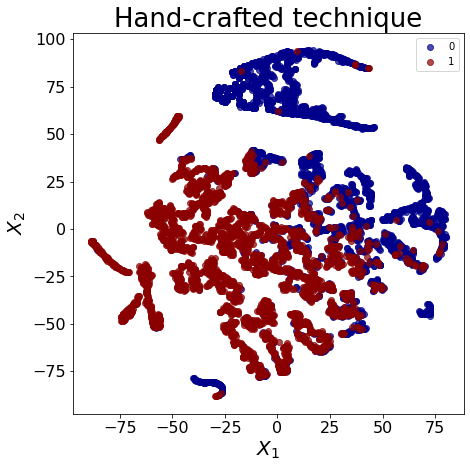

In [ ]:
import numpy as np
groups = pd.DataFrame(weighted_node_embeddings_2d, columns=['x', 'y']).assign(category=labels_train)
names = ['1', '0']

fig, ax = plt.subplots(figsize=(7,7))

X_label1 = groups.query('category==1')
X_label0= groups.query('category==0')
ax.scatter(X_label0['x'], X_label0['y'],alpha=0.7,label=names[1], c='darkblue')
ax.scatter(X_label1['x'], X_label1['y'],alpha=0.7,label=names[0],c='darkred')

ax.set_xlabel('$X_1$',  fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.set_ylabel('$X_2$', fontsize=20)
ax.set_title('Hand-crafted technique', fontsize=26)
ax.legend()
plt.savefig('hc.png')

[Text(0, 0.5, '$X_2$'),
 Text(0.5, 0, '$X_1$'),
 Text(0.5, 1.0, 'visualization of GCN embeddings for cora dataset'),
 None]

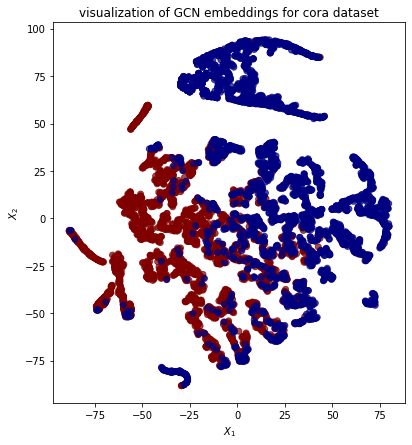

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    weighted_node_embeddings_2d[:, 0],
    weighted_node_embeddings_2d[:, 1],
    c=labels_train,
    cmap="jet",
    alpha=0.7,
)
ax.set(
    aspect="equal",
    xlabel="$X_1$",
    ylabel="$X_2$",
    title="visualization of GCN embeddings for cora dataset",
)

In [ ]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics 

rf = RandomForestClassifier(random_state = 0) 
rf.fit(feat_train, labels_train); 
 
y_pred = rf.predict(feat_test) 
print('Precision:', metrics.precision_score(labels_test, y_pred)) 
print('Recall:', metrics.recall_score(labels_test, y_pred)) 
print('F1-Score:', metrics.f1_score(labels_test, y_pred)) 

Precision: 0.8659868900218499
Recall: 0.9414093428345209
F1-Score: 0.9021244309559939


In [ ]:
print('Accuracy:', metrics.accuracy_score(labels_test, y_pred)) 

Accuracy: 0.8978622327790974


In [ ]:
print(confusion_matrix(labels_test, y_pred))
print(classification_report(labels_test, y_pred, digits=4))

[[3237  552]
 [ 222 3567]]
              precision    recall  f1-score   support

           0     0.9358    0.8543    0.8932      3789
           1     0.8660    0.9414    0.9021      3789

    accuracy                         0.8979      7578
   macro avg     0.9009    0.8979    0.8977      7578
weighted avg     0.9009    0.8979    0.8977      7578



In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=1) 
lr.fit(feat_train, labels_train); 
 
y_pred = lr.predict(feat_test)


In [ ]:
print(confusion_matrix(labels_test, y_pred))
print(classification_report(labels_test, y_pred, digits=4))

[[3346  443]
 [ 327 3462]]
              precision    recall  f1-score   support

           0     0.9110    0.8831    0.8968      3789
           1     0.8866    0.9137    0.8999      3789

    accuracy                         0.8984      7578
   macro avg     0.8988    0.8984    0.8984      7578
weighted avg     0.8988    0.8984    0.8984      7578



In [ ]:
import xgboost as xgb
train_feat_xgboost = np.array(feat_train)

xgb = xgb.XGBClassifier(random_state=1)
xgb.fit(train_feat_xgboost, labels_train); 
 
y_pred = xgb.predict(feat_test)


In [ ]:
print(confusion_matrix(labels_test, y_pred))
print(classification_report(labels_test, y_pred, digits=4))

[[3244  545]
 [ 189 3600]]
              precision    recall  f1-score   support

           0     0.9449    0.8562    0.8984      3789
           1     0.8685    0.9501    0.9075      3789

    accuracy                         0.9031      7578
   macro avg     0.9067    0.9031    0.9029      7578
weighted avg     0.9067    0.9031    0.9029      7578



In [ ]:
importances = xgb.feature_importances_

In [ ]:
feature_names = ['Shortest path', 'Jaccard coefficient', 'The node u centrality', 'The node v centrality','The community to node u','The community to node v']

In [ ]:
import pandas as pd

xgb_importances = pd.Series(importances, index=feature_names)
xgb_importances = xgb_importances.sort_values(ascending=True)
fig, ax = plt.subplots()
xgb_importances.plot.barh(ax=ax)
ax.set_title("Feature importance")
#ax.set_ylabel("Mean decrease in impurity")
plt.savefig("featurei.png")

